In [ ]:
!pip install pytorch-ignite

   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 312.7/312.7 kB 5.8 MB/s eta 0:00:00


In [ ]:
import os
import logging
import matplotlib.pyplot as plt
import torch
import torchvision
import ignite
import numpy as np
from torchsummary import summary
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision.transforms as transforms
import torchvision.utils as vutils
import PIL.Image as Image
from ignite.engine import Engine, Events
from torchvision.datasets import ImageFolder
from ignite.metrics import FID, InceptionScore

In [ ]:
ignite.utils.manual_seed(999)

In [ ]:
image_size = 64

data_transform = transforms.Compose(
    [
        transforms.Resize(image_size),
        transforms.CenterCrop(image_size),
        transforms.ToTensor(),
        transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
    ]
)

In [ ]:
import gdown
import zipfile

In [ ]:
import os

In [ ]:
os.makedirs("celeba_gan")

url = "https://drive.google.com/uc?id=1O7m1010EJjLE5QxLZiM9Fpjs7Oj6e684"
output = "celeba_gan/data.zip"
gdown.download(url, output, quiet=True)

with zipfile.ZipFile("celeba_gan/data.zip", "r") as zipobj:
    zipobj.extractall("celeba_gan")

In [ ]:
ls celeba_gan

data.zip  img_align_celeba/


In [ ]:
train_dataset = torchvision.datasets.ImageFolder('celeba_gan',
               transform=data_transform)
test_dataset = torch.utils.data.Subset(train_dataset, torch.arange(3000))


In [ ]:
batch_size = 128

train_dataloader = torch.utils.data.DataLoader(
    train_dataset,
    batch_size=batch_size,
    shuffle=True,
    drop_last=True,
)

test_dataloader = torch.utils.data.DataLoader(
    test_dataset,
    batch_size=batch_size,
    shuffle=False,
    drop_last=True,
)

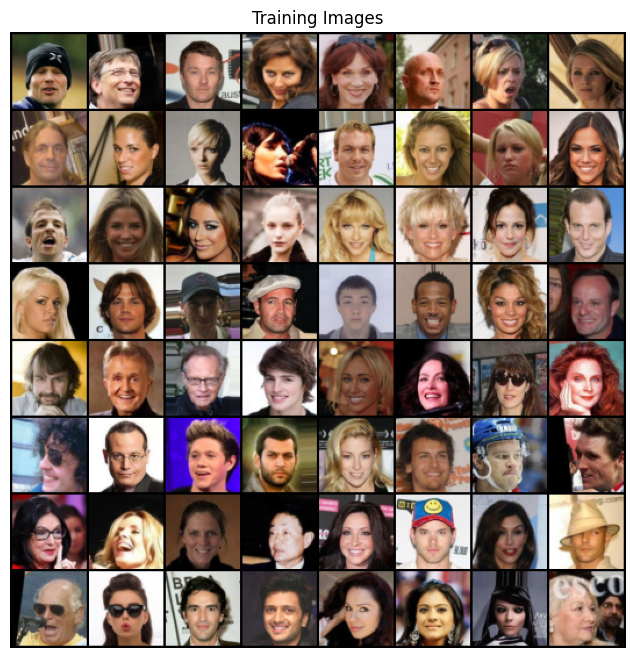

In [ ]:
real_batch = next(iter(train_dataloader))
plt.figure(figsize=(8,8))
plt.axis("off")
plt.title("Training Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=2, normalize=True).cpu(),(1,2,0)))
plt.show()

In [ ]:
latent_dim = 100

In [ ]:
class Generator(nn.Module):
    def __init__(self, latent_dim):
        super(Generator, self).__init__()
        self.model = nn.Sequential(
            nn.ConvTranspose2d(latent_dim, 512, 4, 1, 0, bias=False),
            nn.BatchNorm2d(512),
            nn.ReLU(True),
            nn.ConvTranspose2d(512, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.ReLU(True),
            nn.ConvTranspose2d(256, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.ReLU(True),
            nn.ConvTranspose2d(128, 64, 4, 2, 1, bias=False),
            nn.BatchNorm2d(64),
            nn.ReLU(True),
            nn.ConvTranspose2d(64, 3, 4, 2, 1, bias=False),
            nn.Tanh()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
class Discriminator(nn.Module):
    def __init__(self):
        super(Discriminator, self).__init__()
        self.model = nn.Sequential(
            nn.Conv2d(3, 64, 4, 2, 1, bias=False),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(64, 128, 4, 2, 1, bias=False),
            nn.BatchNorm2d(128),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(128, 256, 4, 2, 1, bias=False),
            nn.BatchNorm2d(256),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(256, 512, 4, 2, 1, bias=False),
            nn.BatchNorm2d(512),
            nn.LeakyReLU(0.2, inplace=True),
            nn.Conv2d(512, 1, 4, 1, 0, bias=False),
            nn.Sigmoid()
        )

    def forward(self, x):
        x = self.model(x)
        return x

In [ ]:
device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

In [ ]:
netG = Generator(latent_dim).to(device)
netD = Discriminator().to(device)

criterion = nn.BCELoss()
fixed_noise = torch.randn(64, latent_dim, 1, 1, device='cuda')
optimizerD = optim.Adam(netD.parameters(), lr=0.0002, betas=(0.5, 0.999))
optimizerG = optim.Adam(netG.parameters(), lr=0.0002, betas=(0.5, 0.999))

In [ ]:
real_label = 1
fake_label = 0


def training_step(engine, data):
    netG.train()
    netD.train()

    netD.zero_grad()

    real = data[0].to(device)
    b_size = real.size(0)
    label = torch.full((b_size,), real_label, dtype=torch.float, device='cuda')
    output1 = netD(real).view(-1)
    errD_real = criterion(output1, label)
    errD_real.backward()
    noise = torch.randn(b_size, latent_dim, 1, 1, device='cuda')
    fake = netG(noise)
    label.fill_(fake_label)
    output2 = netD(fake.detach()).view(-1)
    errD_fake = criterion(output2, label)
    errD_fake.backward()
    errD = errD_real + errD_fake
    optimizerD.step()

    netG.zero_grad()
    label.fill_(real_label)
    output3 = netD(fake).view(-1)
    errG = criterion(output3, label)
    errG.backward()
    optimizerG.step()

    return {
        "Loss_G" : errG.item(),
        "Loss_D" : errD.item(),
        "D_x": output1.mean().item(),
        "D_G_z1": output2.mean().item(),
        "D_G_z2": output3.mean().item(),
    }

In [ ]:
trainer = Engine(training_step)

In [ ]:
fid_metric = FID(device='cuda')
is_metric = InceptionScore(device='cuda', output_transform=lambda x: x[0])

In [ ]:
trainer = Engine(training_step)

fid_metric = FID(device='cuda')
is_metric = InceptionScore(device='cuda', output_transform=lambda x: x[0])

def interpolate(batch):
    arr = []
    for img in batch:
        pil_img = transforms.ToPILImage()(img)
        resized_img = pil_img.resize((299,299), Image.BILINEAR)
        arr.append(transforms.ToTensor()(resized_img))
    return torch.stack(arr)


def evaluation_step(engine, batch):
    with torch.no_grad():
        noise = torch.randn(batch_size, latent_dim, 1, 1, device='cuda')
        netG.eval()
        fake_batch = netG(noise)
        fake = interpolate(fake_batch)
        real = interpolate(batch[0])
        return fake, real

evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=5)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [ ]:
evaluator = Engine(evaluation_step)
fid_metric.attach(evaluator, "fid")
is_metric.attach(evaluator, "is")

In [ ]:
fid_values = []
is_values = []

@trainer.on(Events.EPOCH_COMPLETED)
def log_training_results(engine):
    evaluator.run(test_dataloader,max_epochs=5)
    metrics = evaluator.state.metrics
    fid_score = metrics['fid']
    is_score = metrics['is']
    fid_values.append(fid_score)
    is_values.append(is_score)
    print(f"Epoch [{engine.state.epoch}/5] Metric Scores")
    print(f"*   FID : {fid_score:4f}")
    print(f"*    IS : {is_score:4f}")

In [ ]:
from ignite.metrics import RunningAverage

RunningAverage(output_transform=lambda x: x["Loss_G"]).attach(trainer, 'Loss_G')
RunningAverage(output_transform=lambda x: x["Loss_D"]).attach(trainer, 'Loss_D')

In [ ]:
from ignite.contrib.handlers import ProgressBar

ProgressBar().attach(trainer, metric_names=['Loss_G','Loss_D'])
ProgressBar().attach(evaluator)

In [ ]:
def training(*args):
    trainer.run(train_dataloader, max_epochs=2)

In [ ]:
training()

[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [1/5] Metric Scores
*   FID : 0.065675
*    IS : 2.134589


[1/1582]   0%|           [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

[1/23]   4%|4          [00:00<?]

Epoch [2/5] Metric Scores
*   FID : 0.036847
*    IS : 2.230050


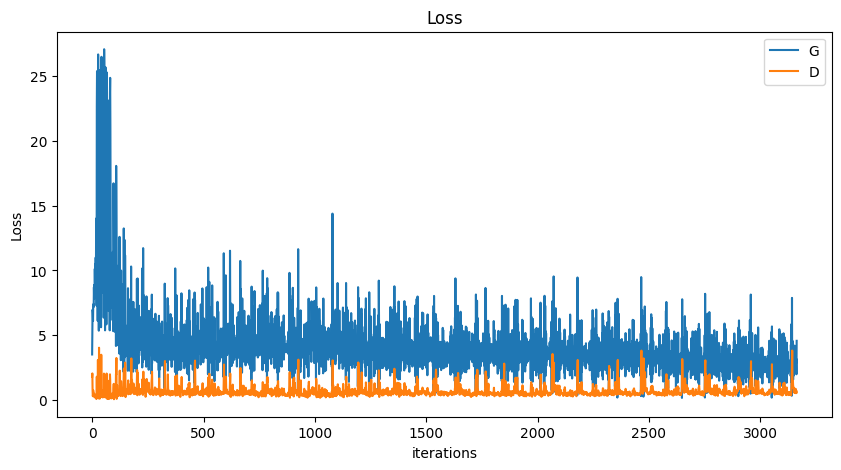

In [ ]:
%matplotlib inline

plt.figure(figsize=(10,5))
plt.title("Loss")
plt.plot(G_losses,label="G")
plt.plot(D_losses,label="D")
plt.xlabel("iterations")
plt.ylabel("Loss")
plt.legend()

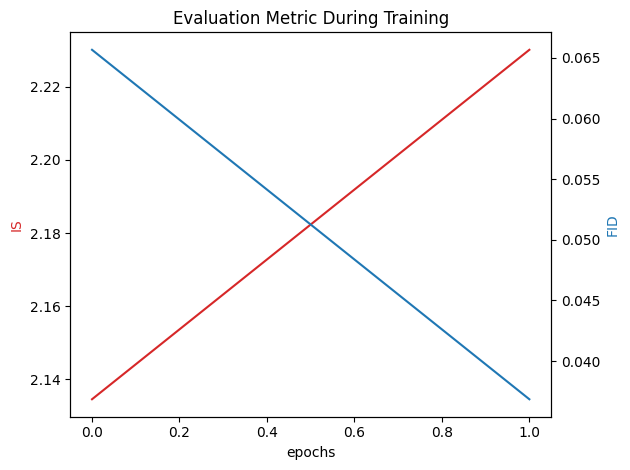

In [ ]:
fig, ax1 = plt.subplots()

plt.title("Evaluation Metric During Training")

color = 'tab:red'
ax1.set_xlabel('epochs')
ax1.set_ylabel('IS', color=color)
ax1.plot(is_values, color=color)

ax2 = ax1.twinx()

color = 'tab:blue'
ax2.set_ylabel('FID', color=color)
ax2.plot(fid_values, color=color)

fig.tight_layout()

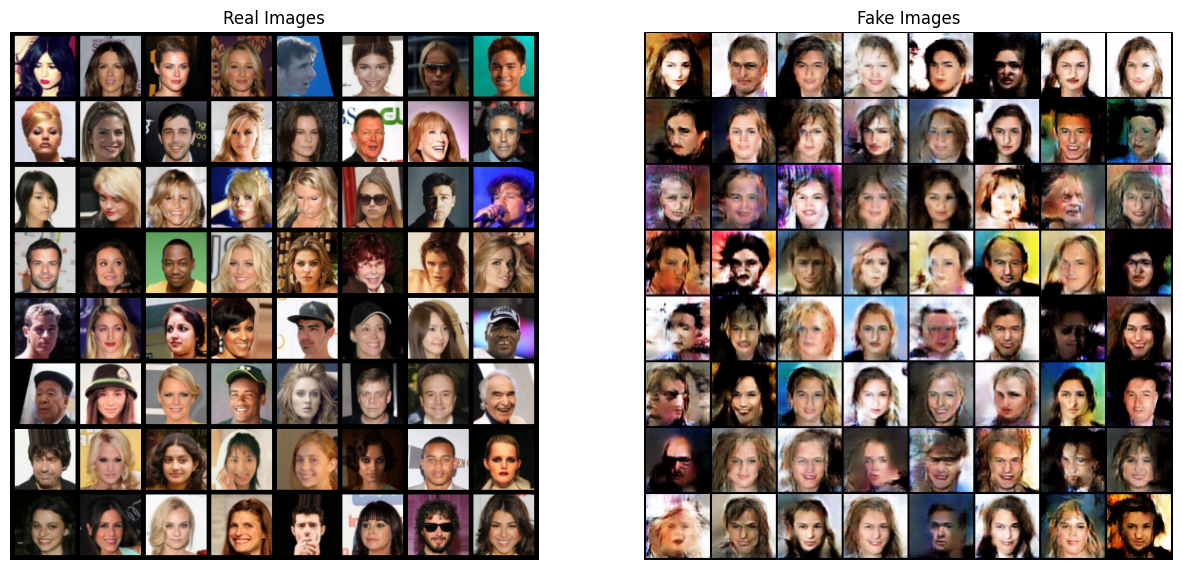

In [ ]:
%matplotlib inline

real_batch = next(iter(train_dataloader))

plt.figure(figsize=(15,15))
plt.subplot(1,2,1)
plt.axis("off")
plt.title("Real Images")
plt.imshow(np.transpose(vutils.make_grid(real_batch[0][:64], padding=5, normalize=True).cpu(),(1,2,0)))

plt.subplot(1,2,2)
plt.axis("off")
plt.title("Fake Images")
plt.imshow(np.transpose(vutils.make_grid(img_list[-1], padding=2, normalize=True).cpu(),(1,2,0)))